# Band Excitation Piezoresponse Force Microscopy(BE-PFM)
### Machine Learning Application
Erin Akinjide
## Objective

This assignment focuses on applying machine learning techniques to my band excitation dataset to explore the features that influence ferroelectric switching. I extend my initial data visualization, preprocess my data, train machine learning models, and evaluate their performance. The goal is to deepen my understanding of machine learning workflows and to enhance my skills in data handling and model evaluation.


## Initial Data Visualization
Band Excitation Piezoresponse Force Microscopy (BE-PFM), an advanced microscopy technique, involves measuring piezoresponse across a range of frequencies near cantilever resonance. A bipolar-triangular switching waveform is applied to fully switch the material domain. 

The resulting data, acquired at every pixel (60x60), provides information on amplitude (A), phase (ϕ), resonance frequency (ω), and quality factor (Q) after fitting. These parameters offer qualitative insights into piezoresponse, polarization direction, stiffness, and dampening at various voltages (V, length = 96).


#### Load Dataset

In [28]:
import h5py
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

Examine dimensions of Features in dataset

In [3]:
data_h5_path = r'C:\Users\erina\Finalproject_BandExcitation\src\Data.h5'
validation_h5_path = r'C:\Users\erina\Finalproject_BandExcitation\src\loop_1.h5'

with h5py.File(data_h5_path, 'r') as h5_data_file, \
        h5py.File(validation_h5_path, 'r') as h5_validation_file:

    # Extract the important information from the HDF5 files
    raw = {
        'voltage': h5_data_file['Voltagedata_mixed'][:],
        'piezoresponse': h5_data_file['Loopdata_mixed'][:],
        'amplitude': h5_data_file['OutA2_mixed'][:],
        'phase': h5_data_file['OutPhi1_mixed'][:],
        'resonance': h5_data_file['Outw2_mixed'][:],
        'quality_factor': h5_data_file['OutQ2_mixed'][:],
        'val_piezoresponse': h5_validation_file['piezo_1'][:],
        'val_resonance': h5_validation_file['resonance_loop_1'][:]
    }

# Now 'raw' dictionary contains the extracted data from the HDF5 files
# Check dimensions of different groups
for key, value in raw.items():
    print(f"Group: {key}, Dimensions: {value.shape}")

Group: voltage, Dimensions: (96, 1)
Group: piezoresponse, Dimensions: (60, 60, 96)
Group: amplitude, Dimensions: (60, 60, 96)
Group: phase, Dimensions: (60, 60, 96)
Group: resonance, Dimensions: (60, 60, 96)
Group: quality_factor, Dimensions: (60, 60, 96)
Group: val_piezoresponse, Dimensions: (60, 60, 96)
Group: val_resonance, Dimensions: (60, 60, 96)


##### Line Plot Showing Priezoresponse as a function of Voltage for three Pixel Location on the Material

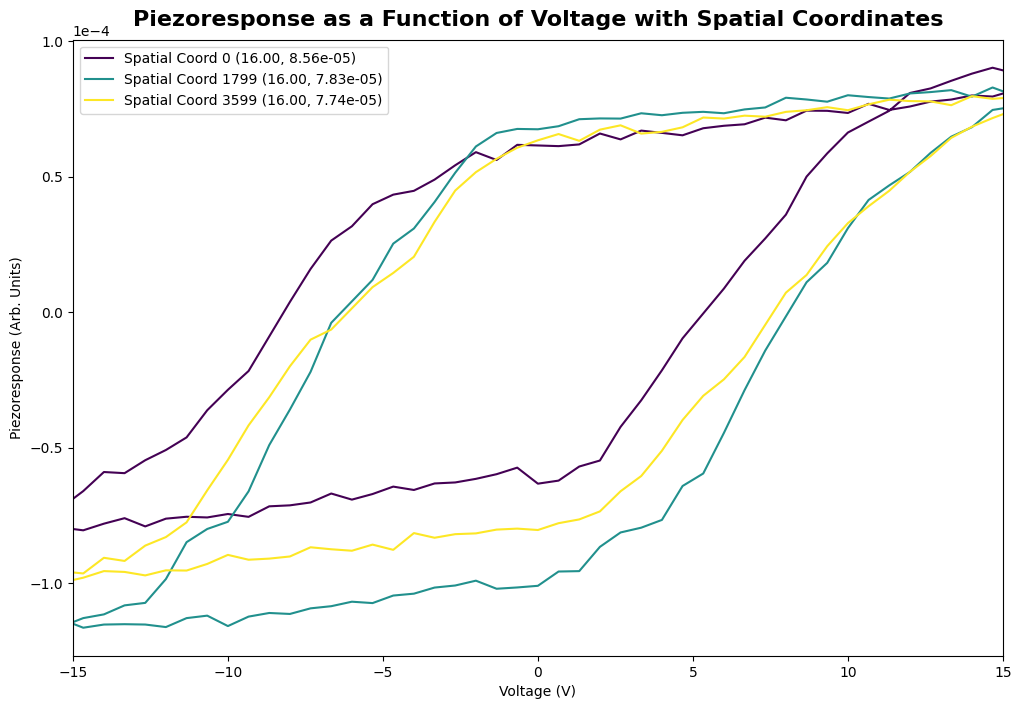

In [4]:
# Extract relevant data for plotting
voltage_values = raw['voltage'].reshape(-1)  # Flatten the voltage array
piezoresponse_data = raw['piezoresponse'].reshape((60 * 60, 96))  # Reshape the piezoresponse data

# Select 5 evenly spaced spatial coordinates for better visibility
spatial_locations_to_plot = np.linspace(0, piezoresponse_data.shape[0] - 1, 3, dtype=int)

# Create a single plot with spatial coordinates represented as colors
fig, ax = plt.subplots(figsize=(12, 8))

# Iterate over selected spatial locations and plot piezoresponse against voltage
for i in spatial_locations_to_plot:
    x_coords = voltage_values
    y_coords = piezoresponse_data[i, :]
    ax.plot(x_coords, y_coords,
            label=f'Spatial Coord {i} ({x_coords[0]:.2f}, {y_coords[0]:.2e})',
            color=plt.cm.viridis(i / piezoresponse_data.shape[0]))

# Set x-axis limits
ax.set_xlim(-15, 15)

# Set x and y axis labels with units
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Piezoresponse (Arb. Units)')

# Add legend
ax.legend()

# Use scientific notation for y-axis ticks
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.title('Piezoresponse as a Function of Voltage with Spatial Coordinates', fontsize=16, fontweight='bold', pad=10)
plt.show()

The roughness in the Line plot above indicates some noise in the signal the data set will need go through filtering preprocessing.

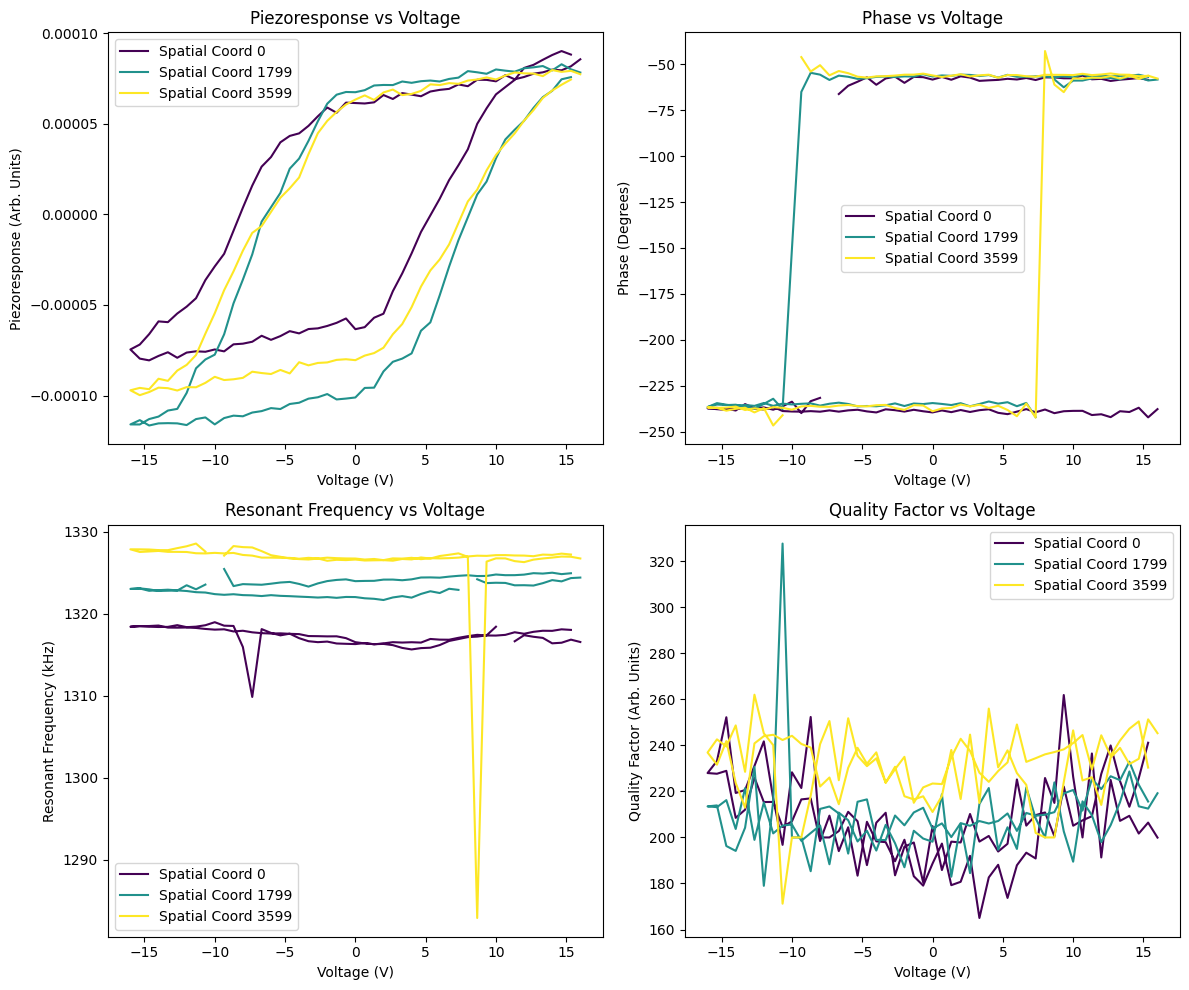

In [5]:
# Extract relevant data for plotting
voltage_values = raw['voltage'].reshape(-1)  # Flatten the voltage array
piezoresponse_data = raw['piezoresponse'].reshape((60 * 60, 96))  # Reshape the piezoresponse data
phase_data = raw['phase'].reshape((60 * 60, 96))  # Reshape the phase data
resonance_data = raw['resonance'].reshape((60 * 60, 96))  # Reshape the resonance data
quality_factor_data = raw['quality_factor'].reshape((60 * 60, 96))  # Reshape the quality factor data

# Set up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Select 3 evenly spaced spatial coordinates for better visibility
spatial_locations_to_plot = np.linspace(0, piezoresponse_data.shape[0] - 1, 3, dtype=int)

# Plot 1: Piezoresponse vs Voltage
axs[0, 0].set_prop_cycle('color', plt.cm.viridis(np.linspace(0, 1, len(spatial_locations_to_plot))))
for i in spatial_locations_to_plot:
    axs[0, 0].plot(voltage_values, piezoresponse_data[i, :], label=f'Spatial Coord {i}')
axs[0, 0].set_xlabel('Voltage (V)')
axs[0, 0].set_ylabel('Piezoresponse (Arb. Units)')
axs[0, 0].set_title('Piezoresponse vs Voltage')
axs[0, 0].legend()

# Plot 2: Phase vs Voltage
axs[0, 1].set_prop_cycle('color', plt.cm.viridis(np.linspace(0, 1, len(spatial_locations_to_plot))))
for i in spatial_locations_to_plot:
    axs[0, 1].plot(voltage_values, phase_data[i, :], label=f'Spatial Coord {i}')
axs[0, 1].set_xlabel('Voltage (V)')
axs[0, 1].set_ylabel('Phase (Degrees)')
axs[0, 1].set_title('Phase vs Voltage')
axs[0, 1].legend()

# Plot 3: Resonant frequency vs Voltage
axs[1, 0].set_prop_cycle('color', plt.cm.viridis(np.linspace(0, 1, len(spatial_locations_to_plot))))
for i in spatial_locations_to_plot:
    axs[1, 0].plot(voltage_values, resonance_data[i, :], label=f'Spatial Coord {i}')
axs[1, 0].set_xlabel('Voltage (V)')
axs[1, 0].set_ylabel('Resonant Frequency (kHz)')
axs[1, 0].set_title('Resonant Frequency vs Voltage')
axs[1, 0].legend()

# Plot 4: Quality Factor vs Voltage
axs[1, 1].set_prop_cycle('color', plt.cm.viridis(np.linspace(0, 1, len(spatial_locations_to_plot))))
for i in spatial_locations_to_plot:
    axs[1, 1].plot(voltage_values, quality_factor_data[i, :], label=f'Spatial Coord {i}')
axs[1, 1].set_xlabel('Voltage (V)')
axs[1, 1].set_ylabel('Quality Factor (Arb. Units)')
axs[1, 1].set_title('Quality Factor vs Voltage')
axs[1, 1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

plt.show()


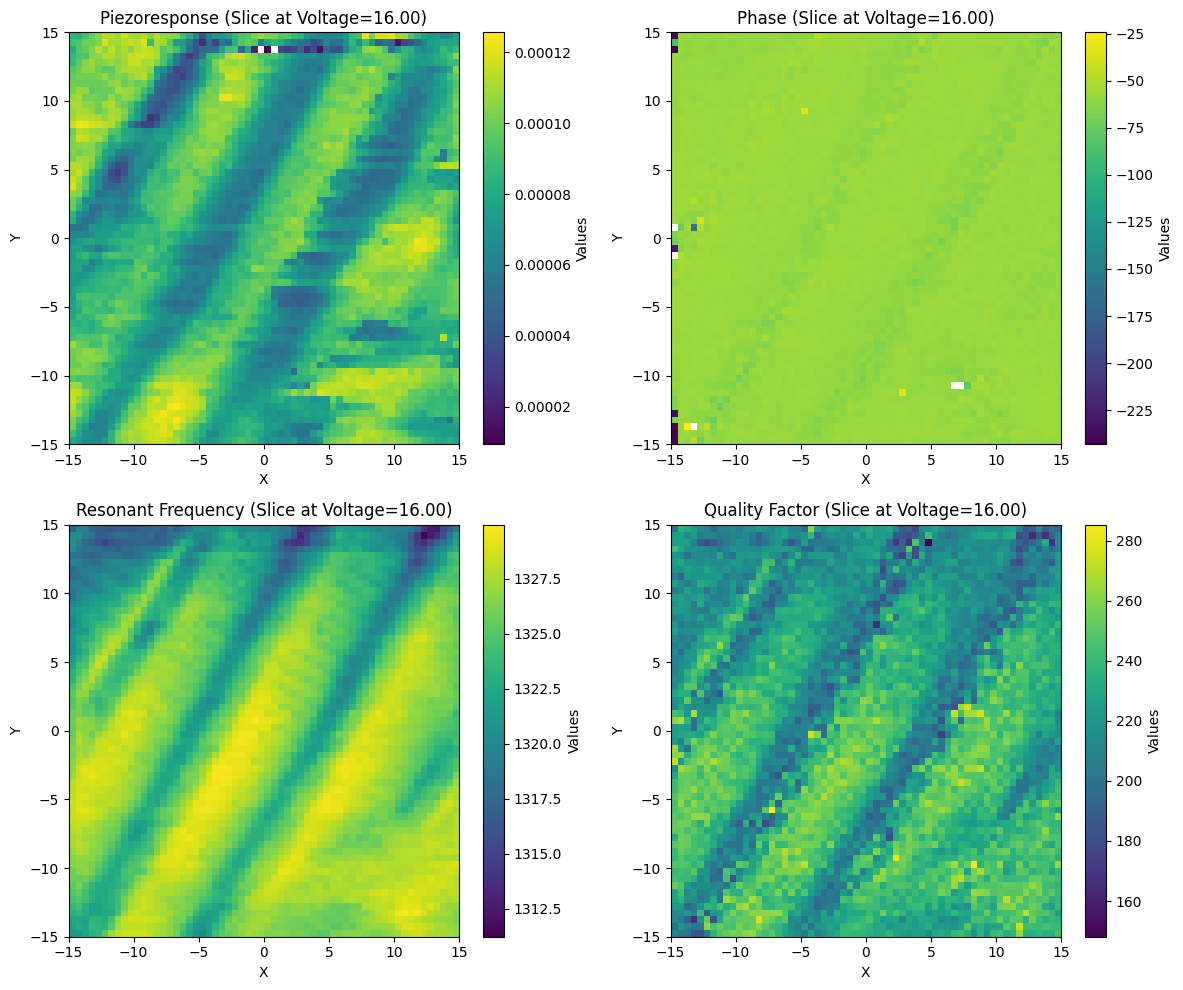

In [6]:
# Extract relevant data for plotting
voltage_values = raw['voltage'].reshape(-1)  # Flatten the voltage array
features_data = {
    'Piezoresponse': raw['piezoresponse'].reshape((60, 60, 96)),
    'Phase': raw['phase'].reshape((60, 60, 96)),
    'Resonant Frequency': raw['resonance'].reshape((60, 60, 96)),
    'Quality Factor': raw['quality_factor'].reshape((60, 60, 96)),
}

# Set up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot heatmaps for each feature
for i, (feature_name, feature_data) in enumerate(features_data.items()):
    ax = axs.flatten()[i]
    im = ax.imshow(feature_data[:, :, 0], cmap='viridis', extent=(-15, 15, -15, 15), aspect='auto')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'{feature_name} (Slice at Voltage={voltage_values[0]:.2f})')
    fig.colorbar(im, ax=ax, label='Values')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

plt.show()

### Data Preprocessing Guide

The line plots above and heatmap indicate that the data needs various forms of preprocessing before any further steps.

Define a set of functions for filtering and processing data, commonly used in signal processing and data analysis. Here's a brief explanation of each function:

1. *range_filter(data, min_max):*

Purpose: Applies a max-min filter to the input data, clipping values outside the specified range (min_max).
Usage: Removes outliers or data points that fall outside the desired range.

2. *clean_interpolate(data, method='linear'):*

Purpose: Interpolates data to handle non-real values in the input data, typically arising from fitting failures or missing values.
Usage: Ensures a continuous and smooth representation of the data by filling in missing or non-real values using interpolation.

3. *savgol(data, fit_type='linear'):*

Purpose: Applies the Savitzky-Golay filter to the input data, a technique for smoothing noisy signals while preserving important features.
Usage: Removes high-frequency noise from the data, making it suitable for subsequent analysis and visualization.

4. *normalize(data, reference=None):*

Purpose: Normalizes the input data by subtracting the mean and dividing by the standard deviation. The optional reference parameter allows normalization based on a reference dataset.
Usage: Ensures that different signals or parameters are on a similar scale, facilitating comparison and analysis.

In [11]:
def range_filter(data, min_max):
    # Apply max min filter on the data to remove bad points
    data_filtered = np.clip(data, min_max[0], min_max[1])
    return data_filtered

def clean_interpolate(data, method='linear'):
    # Interpolate data to handle non-real values
    cleaned_data = np.apply_along_axis(lambda x: np.interp(np.arange(len(x)), np.where(np.isreal(x))[0], x[np.isreal(x)]),
                                       axis=-1, arr=data)
    return cleaned_data

def savgol(data, fit_type='linear'):
    # Use Savitzky-Golay filter to remove outlier points
    filtered_data = savgol_filter(data, window_length=5, polyorder=3, mode='mirror')
    return filtered_data

def normalize(data, reference=None):
    # Normalize the data
    if reference is None:
        reference = data
    normalized_data = (data - np.mean(reference, axis=0)) / np.std(reference, axis=0)
    return normalized_data

def interpolate_nan(data):
    """
    Impute NaN values in a dataset by performing linear interpolation.

    Parameters:
    - data: numpy array
      The input dataset with NaN values.

    Returns:
    - numpy array
      The dataset with NaN values imputed using linear interpolation.
    """
    nan_indices = np.isnan(data)
    data_interpolated = np.copy(data)
    data_interpolated[nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), data[~nan_indices])

    return data_interpolated


   
def handle_inf(data, inf_threshold=1e30):
    # Replace Inf values with threshold
    data_no_inf = np.where(np.isfinite(data), data, inf_threshold)
    return data_no_inf

##### Process the Important groups Using Defined Functions

In [12]:
# Assuming raw is a dictionary containing your feature arrays

# Define the features you want to check
features_to_check = ['voltage', 'piezoresponse', 'amplitude', 'phase', 'resonance', 'quality_factor']

# Function to check for invalid values
def check_invalid_values(feature_name, data):
    invalid_indices = np.isnan(data) | np.isinf(data)
    invalid_count = np.count_nonzero(invalid_indices)
    nan_count = np.count_nonzero(np.isnan(data))
    inf_count = np.count_nonzero(np.isinf(data))

    return invalid_count, nan_count, inf_count

# Function to create sample locations based on feature dimensions
def create_sample_locations(feature_name, feature_dimensions):
    if len(feature_dimensions) == 1:
        # 1D feature, sample locations are indices
        return [(i,) for i in range(feature_dimensions[0])]
    elif len(feature_dimensions) == 2:
        # 2D feature, sample locations are (i, j)
        return [(i, j) for i in range(feature_dimensions[0]) for j in range(feature_dimensions[1])]
    elif len(feature_dimensions) == 3:
        # 3D feature, sample locations are (i, j, k)
        return [(i, j, k) for i in range(feature_dimensions[0]) for j in range(feature_dimensions[1]) for k in range(feature_dimensions[2])]
    else:
        raise ValueError("Unsupported feature dimensions")

# Dictionary to store counts
invalid_counts = {}

# Loop through features
for feature in features_to_check:
    feature_dimensions = raw[feature].shape
    sample_locations = create_sample_locations(feature, feature_dimensions)

    print(f"\nChecking {feature} at sample locations:")
    for location in sample_locations:
        sample_data = raw[feature][location]
        invalid_count, nan_count, inf_count = check_invalid_values(f"{feature} at {location}", sample_data)

        if feature not in invalid_counts:
            invalid_counts[feature] = {'total': 0, 'nan': 0, 'inf': 0}

        invalid_counts[feature]['total'] += invalid_count
        invalid_counts[feature]['nan'] += nan_count
        invalid_counts[feature]['inf'] += inf_count

# Print the counts
for feature, counts in invalid_counts.items():
    print(f"\nFeature: {feature}")
    print(f"  Total Invalid Values: {counts['total']}")
    print(f"  NaN Values: {counts['nan']}")
    print(f"  Inf Values: {counts['inf']}")



Checking voltage at sample locations:

Checking piezoresponse at sample locations:

Checking amplitude at sample locations:

Checking phase at sample locations:

Checking resonance at sample locations:

Checking quality_factor at sample locations:

Feature: voltage
  Total Invalid Values: 0
  NaN Values: 0
  Inf Values: 0

Feature: piezoresponse
  Total Invalid Values: 3
  NaN Values: 3
  Inf Values: 0

Feature: amplitude
  Total Invalid Values: 4003
  NaN Values: 0
  Inf Values: 4003

Feature: phase
  Total Invalid Values: 4176
  NaN Values: 0
  Inf Values: 4176

Feature: resonance
  Total Invalid Values: 0
  NaN Values: 0
  Inf Values: 0

Feature: quality_factor
  Total Invalid Values: 0
  NaN Values: 0
  Inf Values: 0


C:\Users\erina\AppData\Local\Temp\ipykernel_2992\143730152.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate titles


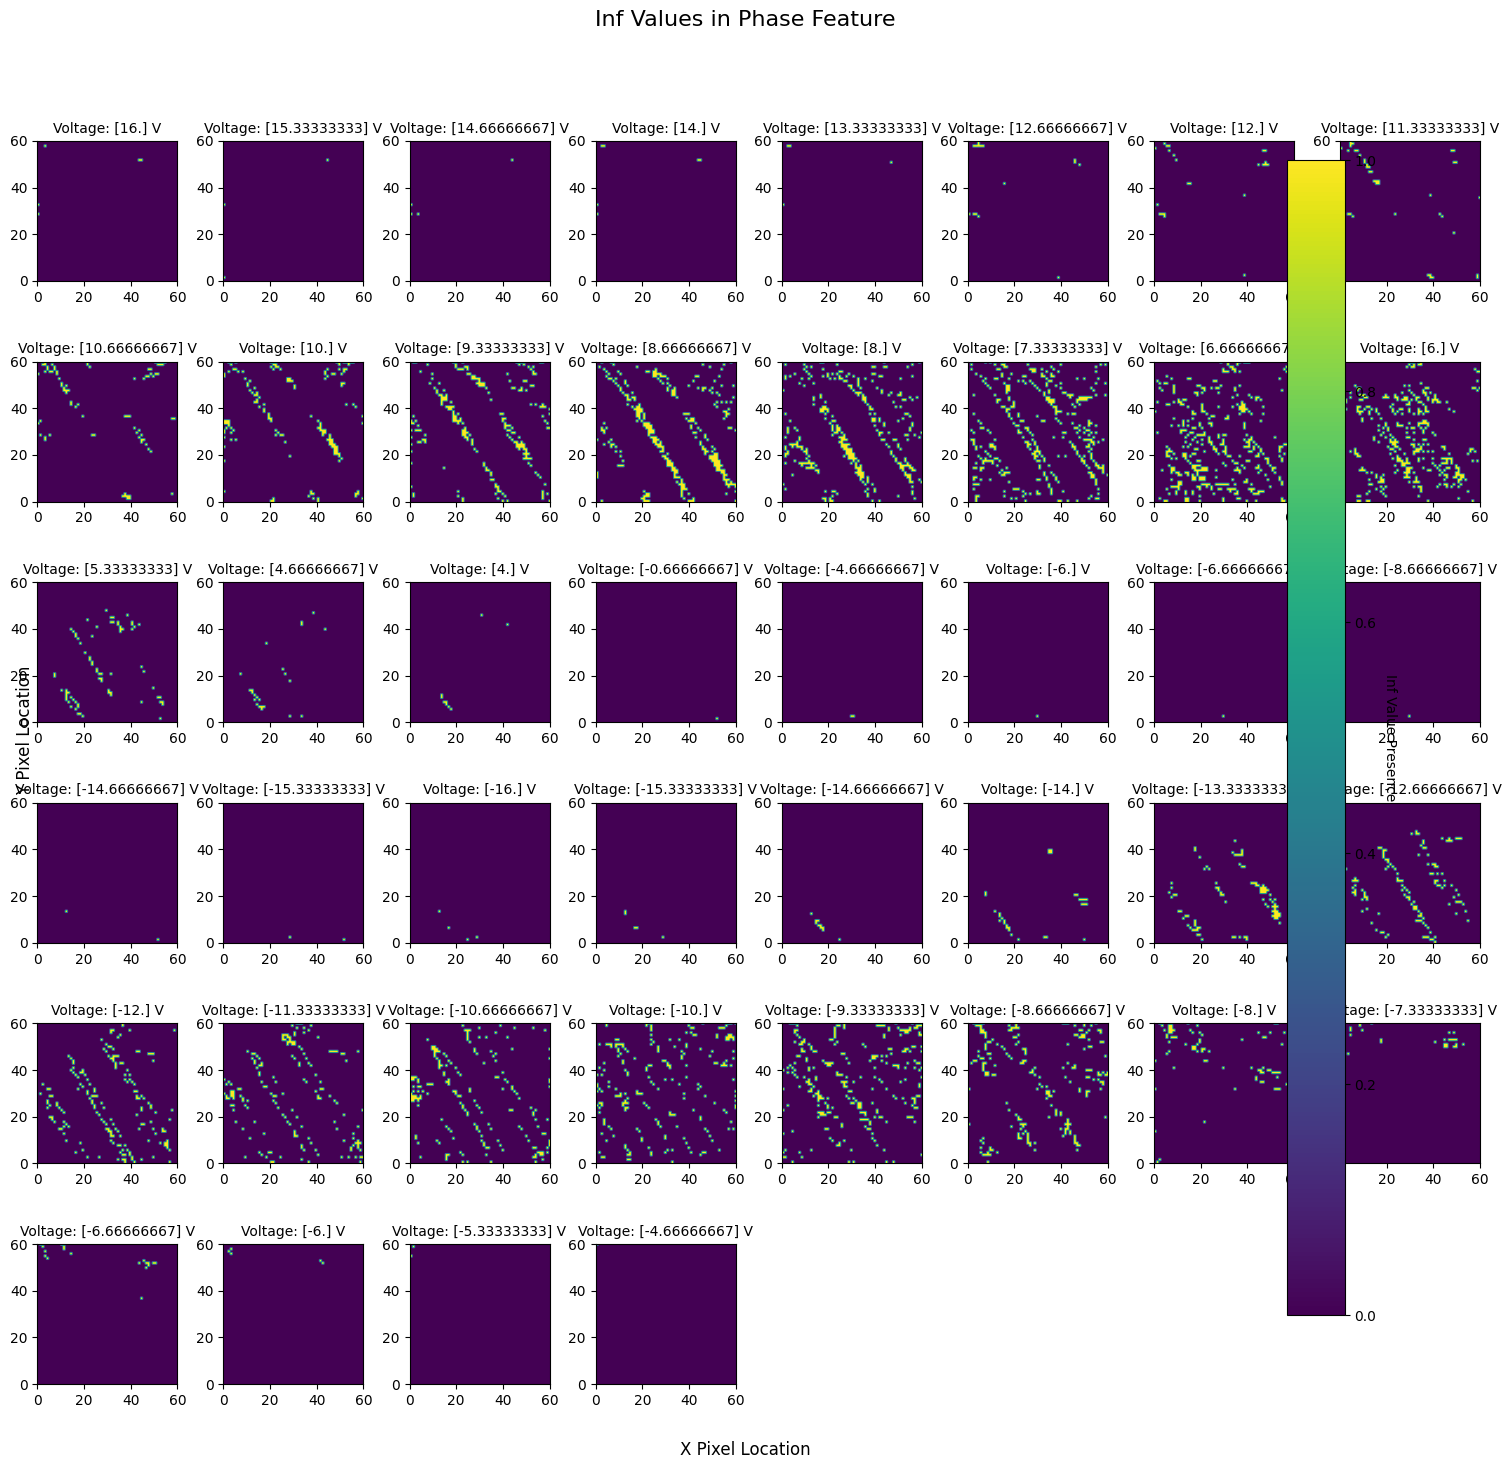

In [13]:
# Assuming 'raw' is your dictionary containing the data
phase_data = raw['phase']
voltage_values = raw['voltage']

# Find indices of Inf values in the phase data
inf_indices = np.isinf(phase_data)

# Determine the number of subplots needed
num_subplots = np.sum(np.any(inf_indices, axis=(0, 1)))

# Determine the layout of the subplots in a square grid
num_rows = int(np.sqrt(num_subplots))
num_cols = int(np.ceil(num_subplots / num_rows))

# Create a figure and set the global title
fig = plt.figure(figsize=(15, 15))
fig.suptitle('Inf Values in Phase Feature', fontsize=16)

# Create subplots
subplot_index = 1
for voltage_index in range(len(voltage_values)):
    if np.any(inf_indices[:, :, voltage_index]):
        ax = fig.add_subplot(num_rows, num_cols, subplot_index)

        # Plot heatmap with Inf values
        cax = ax.imshow(inf_indices[:, :, voltage_index], cmap='viridis', extent=(0, 60, 0, 60), origin='lower')

        # Set subplot title
        ax.set_title(f'Voltage: {voltage_values[voltage_index]} V', fontsize=10)

        subplot_index += 1

# Add colorbar
cbar = fig.colorbar(cax, ax=fig.axes, orientation='vertical', fraction=0.05, pad=0.1)
cbar.set_label('Inf Value Presence', rotation=270, labelpad=15)

# Set common x and y labels
fig.text(0.5, 0.02, 'X Pixel Location', ha='center', va='center', fontsize=12)
fig.text(0.02, 0.5, 'Y Pixel Location', ha='center', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate titles
plt.show()


In [14]:
# Open the HDF5 files
h5_data_file_path = r'C:\Users\erina\Finalproject_BandExcitation\src\Data.h5'  # Replace with the actual path
h5_validation_file_path = r'C:\Users\erina\Finalproject_BandExcitation\src\loop_1.h5'  # Replace with the actual path

with h5py.File(h5_data_file_path, 'r') as h5_data_file, \
        h5py.File(h5_validation_file_path, 'r') as h5_validation_file:

    # Extract the important information from the HDF5 files
    raw = {
        'voltage': h5_data_file['Voltagedata_mixed'][:],
        'piezoresponse': h5_data_file['Loopdata_mixed'][:],
        'amplitude': h5_data_file['OutA2_mixed'][:],
        'phase': h5_data_file['OutPhi1_mixed'][:],
        'resonance': h5_data_file['Outw2_mixed'][:],
        'quality_factor': h5_data_file['OutQ2_mixed'][:],
        'val_piezoresponse': h5_validation_file['piezo_1'][:],
        'val_resonance': h5_validation_file['resonance_loop_1'][:]
    }

    # Add a max-min filter on the data to remove bad points
    p_min_max = [1300, 1340]
    raw['resonance'] = range_filter(raw['resonance'], p_min_max)
    raw['val_resonance'] = range_filter(raw['val_resonance'], p_min_max)

    # Interpolate Nan Values in dataset with neighboring values on the x-axis
    no_nan = { 
        'voltage': raw['voltage'],
       'piezoresponse': interpolate_nan(raw['piezoresponse'] ),
       'amplitude': raw['amplitude'],
        'phase': raw['phase'],
        'resonance': raw['resonance'],
        'quality_factor': raw['quality_factor'],
        'val_piezoresponse': raw['val_piezoresponse'],
        'val_resonance': raw['val_resonance']
    }

    # Apply threshold to inf data types produced by SHO fit.
    no_inf = {
        'voltage': raw['voltage'],
       'piezoresponse': no_nan['piezoresponse'],
       'amplitude': handle_inf(raw['amplitude']),
        'phase': handle_inf(raw['phase']),
        'resonance': raw['resonance'],
        'quality_factor': raw['quality_factor'],
        'val_piezoresponse': raw['val_piezoresponse'],
        'val_resonance': raw['val_resonance']

    }
    # Interpolate data that is non-real (SHO fit failure)
    interpolated = {
        'voltage': raw['voltage'],
        'piezoresponse': clean_interpolate(no_inf['piezoresponse']),
        'amplitude': clean_interpolate(no_inf['amplitude']),
        'phase': clean_interpolate(no_inf['phase']),
        'resonance': clean_interpolate(raw['resonance']),
        'quality_factor': clean_interpolate(raw['quality_factor']),
        'val_piezoresponse': clean_interpolate(raw['val_piezoresponse']),
        'val_resonance': clean_interpolate(raw['val_resonance'])
    }

    # Use Savitzky-Golay filter to remove outlier points
    sg_filtered = {
        'voltage': raw['voltage'],
        'piezoresponse': savgol(interpolated['piezoresponse']),
        'amplitude': savgol(interpolated['amplitude']),
        'phase': savgol(interpolated['phase']),
        'resonance': savgol(interpolated['resonance']),
        'quality_factor': savgol(interpolated['quality_factor']),
        'val_piezoresponse': savgol(interpolated['val_piezoresponse']),
        'val_resonance': savgol(interpolated['val_resonance'])
    }

    # Normalize the data
    normalized = {
        'voltage': raw['voltage'],
        'piezoresponse': normalize(sg_filtered['piezoresponse']),
        'amplitude': normalize(sg_filtered['amplitude']),
        'phase': normalize(sg_filtered['phase']),
        'resonance': normalize(sg_filtered['resonance']),
        'quality_factor': normalize(sg_filtered['quality_factor']),
        'val_piezoresponse': normalize(sg_filtered['val_piezoresponse'], sg_filtered['piezoresponse']),
        'val_resonance': normalize(sg_filtered['val_resonance'], sg_filtered['resonance'])
    }

    

    # Builds a single dictionary to hold all the data
    data = {
        'raw': raw,
        'interpolated': interpolated,
        'sg_filtered': sg_filtered,
        'normalized': normalized,
        'signal_info': signal_info
    }


## Visualize Preprocessed Data

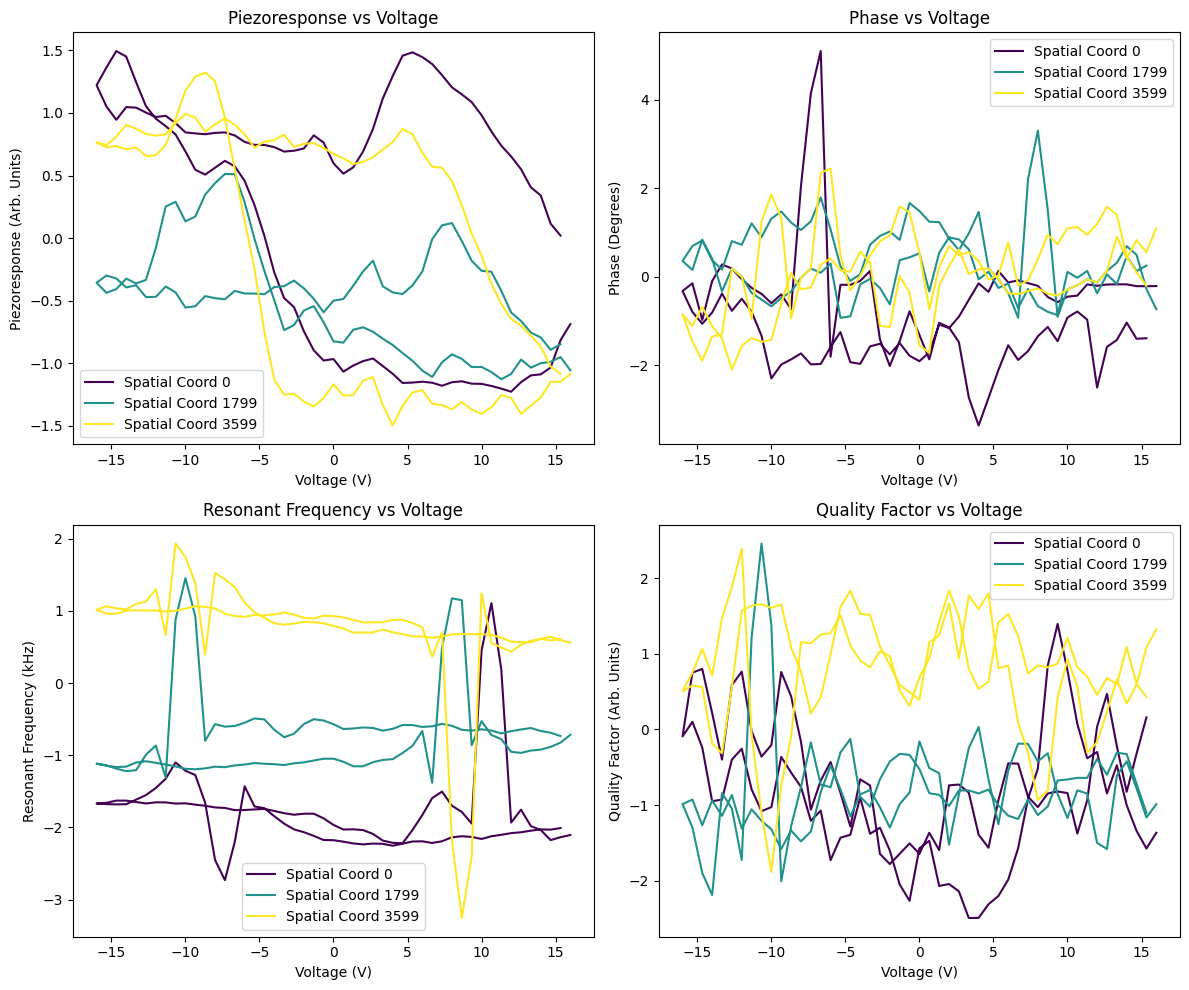

In [16]:
# Extract relevant data for plotting
voltage_values = normalized['voltage'].reshape(-1)  # Flatten the voltage array
piezoresponse_data = normalized['piezoresponse'].reshape((60 * 60, 96))  # Reshape the piezoresponse data
phase_data = normalized['phase'].reshape((60 * 60, 96))  # Reshape the phase data
resonance_data = normalized['resonance'].reshape((60 * 60, 96))  # Reshape the resonance data
quality_factor_data = normalized['quality_factor'].reshape((60 * 60, 96))  # Reshape the quality factor data

# Set up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Select 3 evenly spaced spatial coordinates for better visibility
spatial_locations_to_plot = np.linspace(0, piezoresponse_data.shape[0] - 1, 3, dtype=int)

# Plot 1: Piezoresponse vs Voltage
axs[0, 0].set_prop_cycle('color', plt.cm.viridis(np.linspace(0, 1, len(spatial_locations_to_plot))))
for i in spatial_locations_to_plot:
    axs[0, 0].plot(voltage_values, piezoresponse_data[i, :], label=f'Spatial Coord {i}')
axs[0, 0].set_xlabel('Voltage (V)')
axs[0, 0].set_ylabel('Piezoresponse (Arb. Units)')
axs[0, 0].set_title('Piezoresponse vs Voltage')
axs[0, 0].legend()

# Plot 2: Phase vs Voltage
axs[0, 1].set_prop_cycle('color', plt.cm.viridis(np.linspace(0, 1, len(spatial_locations_to_plot))))
for i in spatial_locations_to_plot:
    axs[0, 1].plot(voltage_values, phase_data[i, :], label=f'Spatial Coord {i}')
axs[0, 1].set_xlabel('Voltage (V)')
axs[0, 1].set_ylabel('Phase (Degrees)')
axs[0, 1].set_title('Phase vs Voltage')
axs[0, 1].legend()

# Plot 3: Resonant frequency vs Voltage
axs[1, 0].set_prop_cycle('color', plt.cm.viridis(np.linspace(0, 1, len(spatial_locations_to_plot))))
for i in spatial_locations_to_plot:
    axs[1, 0].plot(voltage_values, resonance_data[i, :], label=f'Spatial Coord {i}')
axs[1, 0].set_xlabel('Voltage (V)')
axs[1, 0].set_ylabel('Resonant Frequency (kHz)')
axs[1, 0].set_title('Resonant Frequency vs Voltage')
axs[1, 0].legend()

# Plot 4: Quality Factor vs Voltage
axs[1, 1].set_prop_cycle('color', plt.cm.viridis(np.linspace(0, 1, len(spatial_locations_to_plot))))
for i in spatial_locations_to_plot:
    axs[1, 1].plot(voltage_values, quality_factor_data[i, :], label=f'Spatial Coord {i}')
axs[1, 1].set_xlabel('Voltage (V)')
axs[1, 1].set_ylabel('Quality Factor (Arb. Units)')
axs[1, 1].set_title('Quality Factor vs Voltage')
axs[1, 1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

plt.show()

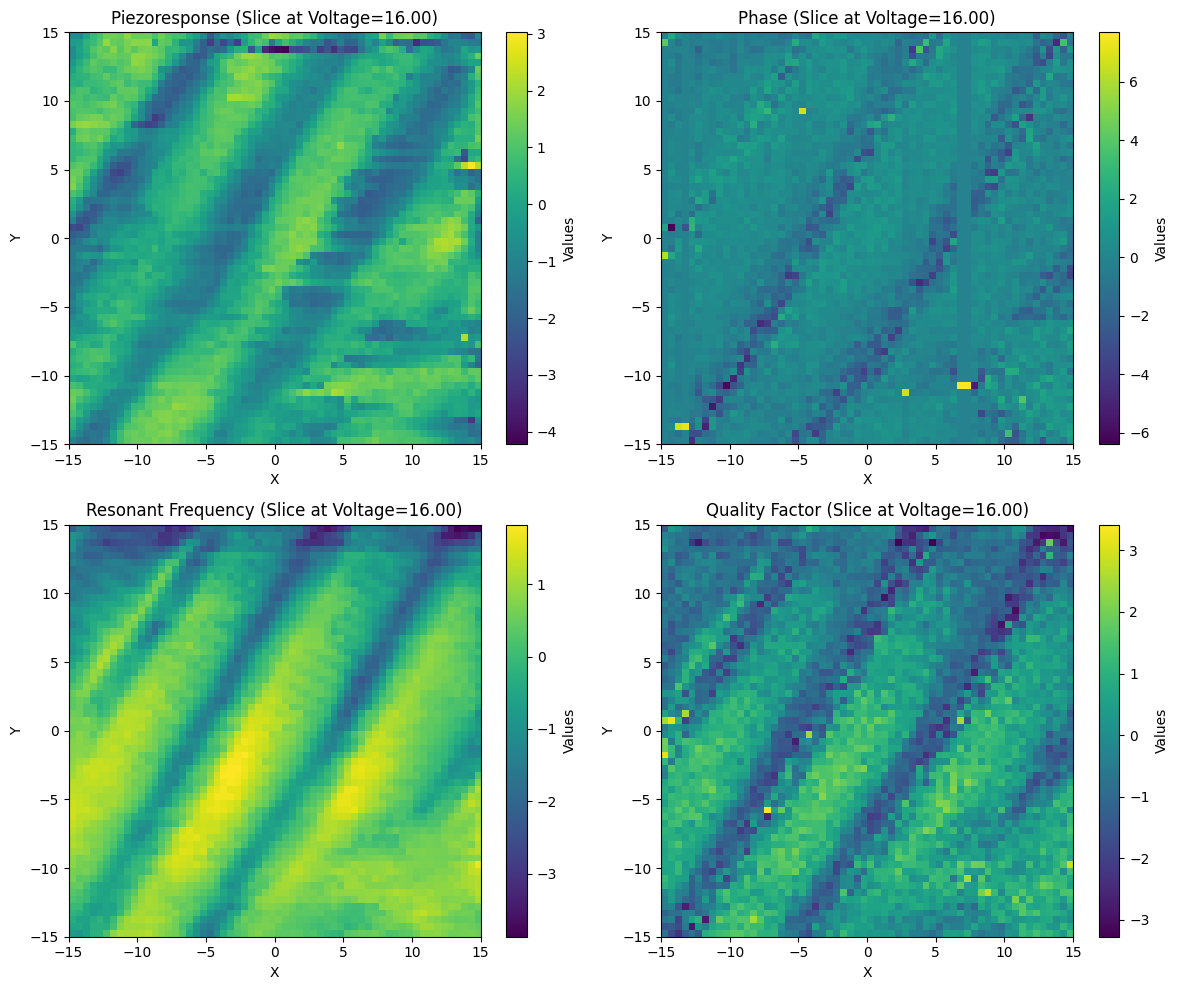

In [17]:
voltage_values = normalized['voltage'].reshape(-1)  # Flatten the voltage array
features_data = {
    'Piezoresponse': normalized['piezoresponse'].reshape((60, 60, 96)),
    'Phase': normalized['phase'].reshape((60, 60, 96)),
    'Resonant Frequency': normalized['resonance'].reshape((60, 60, 96)),
    'Quality Factor': normalized['quality_factor'].reshape((60, 60, 96)),
}

# Set up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot heatmaps for each feature
for i, (feature_name, feature_data) in enumerate(features_data.items()):
    ax = axs.flatten()[i]
    im = ax.imshow(feature_data[:, :, 0], cmap='viridis', extent=(-15, 15, -15, 15), aspect='auto')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'{feature_name} (Slice at Voltage={voltage_values[0]:.2f})')
    fig.colorbar(im, ax=ax, label='Values')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

plt.show()

## Machine Learning Problem Description: Predicting Piezoresponse from Band Excitation Dataset

#### Objective:
The machine learning problem at hand involves predicting the piezoresponse of a material based on a dataset obtained from a Band Excitation experiment. The raw data from the experiment has been processed and fitted to a Simple Harmonic Oscillator (SHO) to extract relevant features such as amplitude, phase, quality factor, and piezoresponse. The target variable for prediction is the piezoresponse, and the features are spatially mapped to a 60 by 60 grid for 96 different voltage values.

#### Challenges:
Spatial and Temporal Variability:

The dataset's spatial variability across the grid and temporal variability across different voltage values introduce additional complexity. The model needs to generalize well across these variations.

Spatial Relationships:

Spatial relationships between pixels might play a significant role in the piezoresponse. Standard machine learning models may struggle to capture spatial dependencies. Advanced techniques or spatially aware models may be necessary.

Model Complexity:

Choosing an appropriate model complexity is vital. Overly complex models may lead to overfitting, especially with a limited dataset. On the other hand, overly simplistic models may fail to capture the underlying patterns.

## Model Training and Hyparameter Tuning


In [19]:
# Step 1: Prepare the Data
features = np.stack([
    normalized['amplitude'].flatten(),
    normalized['phase'].flatten(),
    normalized['resonance'].flatten(),
    normalized['quality_factor'].flatten()
], axis=-1)

target = normalized['piezoresponse'].flatten()

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)



In [21]:

# Step 2: Create and Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=30, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=30, random_state=42)

In [22]:
# Step 3: Evaluate the Model
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.9443756035918928
R-squared: 0.053202375253670886


Note: The model does not accurately understand the relationship between the features and the piezoresponse of the material due to complex nature of the dataset.
An R-squared of 0.0532 suggests that only a small proportion (5.32%) of the variance in the piezoresponse is explained by your model. This might indicate that the features you are using or the model itself may not be capturing the underlying patterns in the data very well.
Each point on the plot represents a data point in your test set. A perfect model would produce a diagonal line.

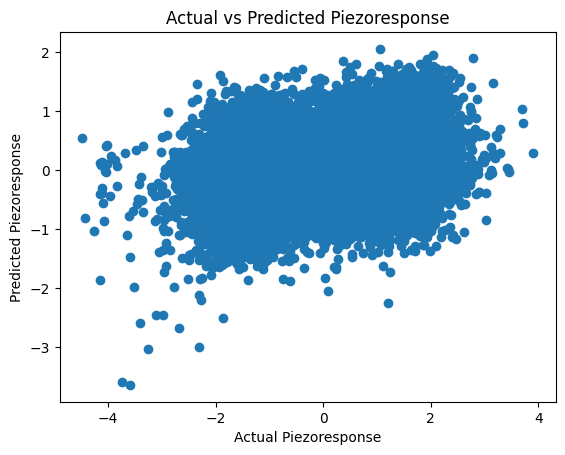

In [23]:

# Step 4: Visualization (Optional)
# You can visualize the predicted vs actual values if you want
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Piezoresponse")
plt.ylabel("Predicted Piezoresponse")
plt.title("Actual vs Predicted Piezoresponse")
plt.show()


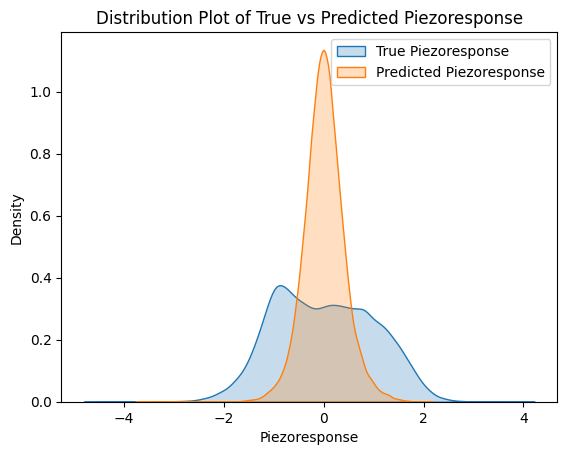

In [27]:

sns.kdeplot(y_test, label='True Piezoresponse', fill=True)
sns.kdeplot(y_pred, label='Predicted Piezoresponse', fill=True)
plt.xlabel('Piezoresponse')
plt.title('Distribution Plot of True vs Predicted Piezoresponse')
plt.legend()
plt.show()


Visualize the residuals (the differences between true and predicted values). A good model would have residuals distributed randomly around zero.

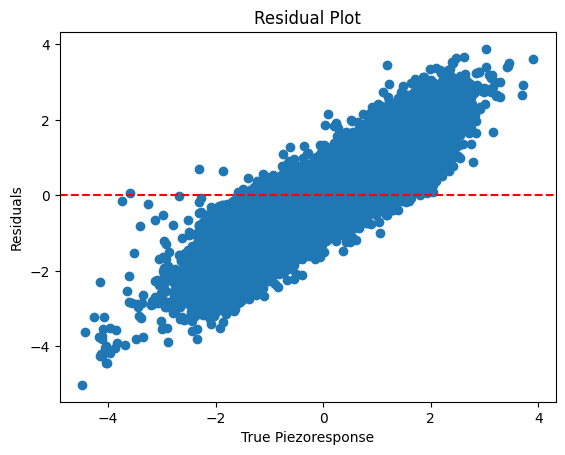

In [29]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel('True Piezoresponse')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.show()



## Improvement Strategies

